# Manufacturing Test Data Analysis

This jupyter notebook will be used to perform some analysis of some sample manufacturing test data. The python script in this repository performs the necessary steps to pull down data from a Google Sheet and populate a SQLite database using a pandas dataframe as an intermediary. For convenience, this jupyter notebook starts from a csv file instead of from a Google Sheet. 

The steps are:
1. Read the data from the csv file into a pandas dataframe.
2. Clean up the data.
3. Plot and analyze the data.
4. Conclude whether or not a test phase should be eliminated or kept.

## Libraries

In [1]:
import unittest
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sn

# 1. Read data from csv

In [2]:
# Ingest the csv file into a pandas dataframe.
csv_file_name = "mfg-data.csv"
df = pd.read_csv(csv_file_name)

# Print the number of rows x columns in the dataframe.
print("dataframe shape:", df.shape)

# Check the first rows of the dataframe to see if the pandas import worked.
df.head()

dataframe shape: (450, 32)


,Serial Number,Date Created,TestingSoftwareVersion,Test Result,status_CL_2,status_CL_25,status_CL_8,status_OL,P_CL_2,P_Avg_CL_25,...,F_StdDev_CL_8,F_StdDev_OL,D_Avg_CL_2,D_Avg_CL_25,D_Avg_CL_8,D_Avg_OL,D_StdDev_CL_2,D_StdDev_CL_25,D_StdDev_CL_8,D_StdDev_OL
0,4A001H,1/23/2018 10:49,3.2,Pass,Pass,Pass,Pass,Pass,"29,335.58","29,491.29",...,57.42083,45.50565,368.1233,"4,182.69",1350.583,2383.093,19.25788,17.21346,15.86988,11.74825
1,4A001H,1/23/2018 10:49,3.2,Fail,Pass,Fail,Pass,Pass,"29,283.49","29,633.68",...,61.96784,44.54431,372.3033,"4,497.02",1339.677,2396.403,16.08281,985.31040,16.53243,11.21949
2,4A001P,1/23/2018 10:15,3.2,Pass,Pass,Pass,Pass,Pass,"29,305.18","29,363.80",...,60.35593,47.61033,412.07,3849.643,1316.22,2402.773,18.30341,16.72933,14.27912,11.31950
3,4A001M,1/23/2018 10:02,3.2,Pass,Pass,Pass,Pass,Pass,"29,281.21","29,302.74",...,52.70877,52.20287,319.48,3205.407,1072.523,2387.513,15.92340,30.93753,13.09100,12.09733
4,4A001K,1/23/2018 9:47,3.2,Pass,Pass,Pass,Pass,Pass,"29,390.77","29,342.95",...,60.10137,41.39107,348.8233,3549.727,1196.373,2405.407,12.25349,18.39503,13.93871,10.74339


# 2. Cleanup the data

## 2.1 Cleanup column names to make plotting and analysis easier.

In [3]:
# Cleanup column names to all lowercase with underscores instead of spaces.
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
print("New column names:")
print(df.columns)

New column names:
Index(['serial_number', 'date_created', 'testingsoftwareversion',
       'test_result', 'status_cl_2', 'status_cl_25', 'status_cl_8',
       'status_ol', 'p_cl_2', 'p_avg_cl_25', 'p_avg_cl_8', 'p_avg_ol',
       'p_stddev_cl_2', 'p_stddev_cl_25', 'p_stddev_cl_8', 'p_stddev_ol',
       'f_avg_cl_2', 'f_avg_cl_25', 'f_avg_cl_8', 'f_avg_ol', 'f_stddev_cl_2',
       'f_stddev_cl_25', 'f_stddev_cl_8', 'f_stddev_ol', 'd_avg_cl_2',
       'd_avg_cl_25', 'd_avg_cl_8', 'd_avg_ol', 'd_stddev_cl_2',
       'd_stddev_cl_25', 'd_stddev_cl_8', 'd_stddev_ol'],
      dtype='object')


## 2.2 Unit test a few values for correctness with the Google Sheet

In [4]:
# Test the dataframe to make sure it contains correct values in some known positions.
class TestDataframe(unittest.TestCase):
	
	def test_some_column_names(self):
		self.assertEqual(df.columns.values.tolist()[0], "serial_number")
		self.assertEqual(df.columns.values.tolist()[31], "d_stddev_ol")

	def test_some_first_data_row_values(self):
		self.assertEqual(df.at[0,"serial_number"], "4A001H")
		self.assertEqual(df.at[0, "p_cl_2"], "29,335.58")

	def test_some_final_data_row_values(self):
		self.assertEqual(df.at[449, "serial_number"], "3C005V")
		self.assertEqual(df.at[449, "d_stddev_ol"], 0)
		
# Run the unittests
unittest.main(argv=[''], verbosity=1, exit=False)

...
----------------------------------------------------------------------
Ran 3 tests in 0.002s

OK


## 2.3 Convert numerical data from strings to numbers

In [5]:
# First check what datatypes each column has.
df.dtypes

serial_number              object
date_created               object
testingsoftwareversion    float64
test_result                object
status_cl_2                object
status_cl_25               object
status_cl_8                object
status_ol                  object
p_cl_2                     object
p_avg_cl_25                object
p_avg_cl_8                 object
p_avg_ol                   object
p_stddev_cl_2             float64
p_stddev_cl_25            float64
p_stddev_cl_8             float64
p_stddev_ol                object
f_avg_cl_2                float64
f_avg_cl_25                object
f_avg_cl_8                float64
f_avg_ol                   object
f_stddev_cl_2             float64
f_stddev_cl_25            float64
f_stddev_cl_8             float64
f_stddev_ol                object
d_avg_cl_2                 object
d_avg_cl_25                object
d_avg_cl_8                 object
d_avg_ol                   object
d_stddev_cl_2             float64
d_stddev_cl_25

We can see that some of the numerical data is represented as floats and some as objects.
It's better to convert all the numerical data to floats.

In [6]:
columns_with_numerical_data = ["p_cl_2", "p_avg_cl_25", "p_avg_cl_8", "p_avg_ol", "p_stddev_ol",
                              "f_avg_cl_25", "f_avg_ol", "f_stddev_ol", "d_avg_cl_2", "d_avg_cl_25",
                              "d_avg_cl_8", "d_avg_ol"]

# Remove commas and whitespace.
for column in columns_with_numerical_data:
    df[column] = df[column].apply(lambda x : x.strip().replace(',', '')) 
  
# Convert the data type to float.
df[columns_with_numerical_data] = df[columns_with_numerical_data].astype(float)

## 2.4 Convert categorical data from strings to numbers

In [7]:
# For example, plotting and analysis will be easier if we encode "Pass" as 1 and "Fail" as 0.
# Note that we will intentionally keep any NaN values instead of changing them.
columns_with_categorical_data = ["test_result", "status_cl_2", "status_cl_25", "status_cl_8", "status_ol"]

status_mapping = {"Pass": 1, "Fail": 0}

for column in columns_with_categorical_data:
    df[column] = df[column].map(status_mapping)

df[columns_with_categorical_data] = df[columns_with_categorical_data].astype(float)

## 2.5 Convert timestamp strings to pandas date time object

In [8]:
df["date_created"] = pd.to_datetime(df["date_created"])    
df.head()

,serial_number,date_created,testingsoftwareversion,test_result,status_cl_2,status_cl_25,status_cl_8,status_ol,p_cl_2,p_avg_cl_25,...,f_stddev_cl_8,f_stddev_ol,d_avg_cl_2,d_avg_cl_25,d_avg_cl_8,d_avg_ol,d_stddev_cl_2,d_stddev_cl_25,d_stddev_cl_8,d_stddev_ol
0,4A001H,2018-01-23 10:49:00,3.2,1.0,1.0,1.0,1.0,1.0,29335.58,29491.29,...,57.42083,45.50565,368.1233,4182.690,1350.583,2383.093,19.25788,17.21346,15.86988,11.74825
1,4A001H,2018-01-23 10:49:00,3.2,0.0,1.0,0.0,1.0,1.0,29283.49,29633.68,...,61.96784,44.54431,372.3033,4497.020,1339.677,2396.403,16.08281,985.31040,16.53243,11.21949
2,4A001P,2018-01-23 10:15:00,3.2,1.0,1.0,1.0,1.0,1.0,29305.18,29363.80,...,60.35593,47.61033,412.0700,3849.643,1316.220,2402.773,18.30341,16.72933,14.27912,11.31950
3,4A001M,2018-01-23 10:02:00,3.2,1.0,1.0,1.0,1.0,1.0,29281.21,29302.74,...,52.70877,52.20287,319.4800,3205.407,1072.523,2387.513,15.92340,30.93753,13.09100,12.09733
4,4A001K,2018-01-23 09:47:00,3.2,1.0,1.0,1.0,1.0,1.0,29390.77,29342.95,...,60.10137,41.39107,348.8233,3549.727,1196.373,2405.407,12.25349,18.39503,13.93871,10.74339


# 3. Data Analysis

## 3.1 For each column, how many missing or strange values are there?

In [9]:
df.describe()

,testingsoftwareversion,test_result,status_cl_2,status_cl_25,status_cl_8,status_ol,p_cl_2,p_avg_cl_25,p_avg_cl_8,p_avg_ol,...,f_stddev_cl_8,f_stddev_ol,d_avg_cl_2,d_avg_cl_25,d_avg_cl_8,d_avg_ol,d_stddev_cl_2,d_stddev_cl_25,d_stddev_cl_8,d_stddev_ol
count,442.00000,449.000000,448.000000,439.000000,445.000000,438.000000,450.000000,450.000000,450.000000,450.000000,...,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000
mean,3.16267,0.634744,0.845982,0.808656,0.761798,0.910959,28799.197157,28276.903652,28721.657367,29524.249059,...,60.467758,48.716788,1235.547416,5053.995682,2221.062660,2693.984165,27.889232,120.312266,19.559376,19.542673
std,0.30807,0.482039,0.361369,0.393808,0.426463,0.285129,3378.416414,5189.755529,4025.079281,5257.695063,...,54.313106,192.998113,3611.996076,3451.207699,3408.849674,2723.632552,116.693975,224.798688,36.967677,130.165722
min,-3.20000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-1171.640000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.20000,0.000000,1.000000,1.000000,1.000000,1.000000,29291.465000,29312.572500,29389.030000,30641.955000,...,50.419602,35.725210,337.739200,3583.889000,1192.574750,2402.853000,15.549385,16.148933,14.172213,9.896221
50%,3.20000,1.000000,1.000000,1.000000,1.000000,1.000000,29333.950000,29405.045000,29430.550000,30654.435000,...,55.875610,39.649770,450.998350,4160.360000,1448.913500,2421.101500,17.120565,22.545610,15.557350,10.800455
75%,3.20000,1.000000,1.000000,1.000000,1.000000,1.000000,29373.927500,29469.155000,29468.365000,30666.375000,...,61.902687,44.539195,579.698325,5594.235000,1877.993250,2438.877000,18.937040,45.488245,17.288137,11.778422
max,3.20000,1.000000,1.000000,1.000000,1.000000,1.000000,29617.930000,29663.160000,29584.620000,30684.300000,...,851.725800,4087.230000,36387.250000,36391.400000,36395.960000,36346.890000,2324.910000,1180.899000,502.569800,2086.337000


The first row in the above chart is named "count". It tells us how many data cells were counted in each column. We can see that each of the test status columns has at least a few data points missing whereas the numerical data columns (average, std. dev.) have all 450 data points.

## 3.2 Are the different tests correlated?

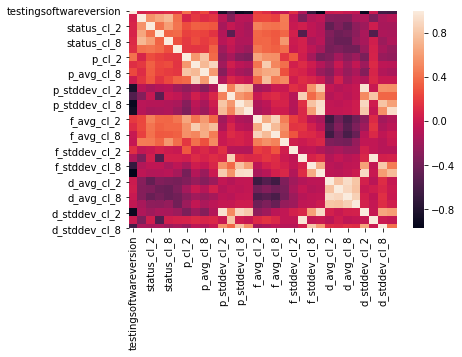

test_result               1.000000
status_cl_8               0.737862
status_cl_25              0.650110
status_cl_2               0.556424
f_avg_ol                  0.457752
status_ol                 0.399284
f_stddev_cl_25            0.346497
d_stddev_cl_25            0.344244
d_avg_cl_8                0.316465
d_avg_cl_25               0.316345
p_stddev_cl_25            0.314120
d_avg_cl_2                0.298123
f_avg_cl_25               0.248483
f_avg_cl_2                0.238316
f_avg_cl_8                0.212641
p_avg_cl_25               0.178361
p_avg_ol                  0.167699
d_avg_ol                  0.150728
d_stddev_cl_8             0.139576
p_avg_cl_8                0.124015
d_stddev_cl_2             0.118496
f_stddev_cl_8             0.101662
d_stddev_ol               0.089411
p_stddev_ol               0.083336
p_stddev_cl_8             0.078234
p_cl_2                    0.076891
p_stddev_cl_2             0.069445
testingsoftwareversion    0.062761
f_stddev_ol         

In [41]:
# First heatmap
big_correlation_matrix = df.corr()
sn.heatmap(big_correlation_matrix, annot=False)
plt.show()
#print(big_correlation_matrix)

test_result_corr_vector = big_correlation_matrix[:]["test_result"]
test_result_corr_vector = test_result_corr_vector.abs() # Absolute value
sorted_results = test_result_corr_vector.sort_values(ascending=False)
#print(test_result_corr_vector)
print(sorted_results)
#print(test_result_corr_vector.shape)


## Heatmap Analysis Part 1

We can use a correlation matrix with a heatmap to quickly visualize which of the 30 variables are strongly or weakly correlated with the test_result. The top results are:
0. test_result = 1.000
1. status_cl_8 = 0.738
2. status_cl_25 = 0.650
3. status_cl_2 = 0.556
4. f_avg_ol = 0.458
5. status_ol = 0.399
6. f_stddev_cl_25 = 0.346

We can disregard the top result "test_result" since any feature will perfectly correlate with itself.

Interestingly, "f_avg_ol" has slightly better correlation than its respective test: "status_ol"


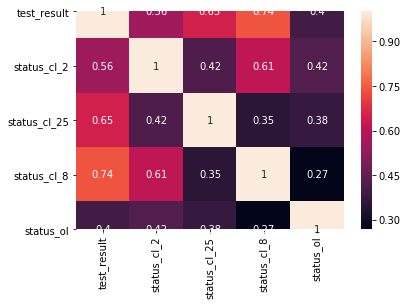

              test_result  status_cl_2  status_cl_25  status_cl_8  status_ol
test_result      1.000000     0.556424      0.650110     0.737862   0.399284
status_cl_2      0.556424     1.000000      0.417977     0.612691   0.424966
status_cl_25     0.650110     0.417977      1.000000     0.353256   0.377110
status_cl_8      0.737862     0.612691      0.353256     1.000000   0.269209
status_ol        0.399284     0.424966      0.377110     0.269209   1.000000


In [11]:
# Second heatmap
columns_with_categorical_data = ["test_result", "status_cl_2", "status_cl_25", "status_cl_8", "status_ol"]
small_correlation_matrix = df[columns_with_categorical_data].corr()
sn.heatmap(small_correlation_matrix, annot=True)
plt.show()
print(small_correlation_matrix)

## Heatmap Analysis Part 2

In the above heatmaps, we represent the correlation of each individual test phase status with each other. 
The scale of these heatmaps is from +1 (perfectly correlated) as can be seen in the diagonal line, to -1 (perfectly negatively correlated). In the middle lies 0.0 which means no correlation.


Of the 4 phases, we can see that "status_cl_8" has the highest correlation with the overall "test_result" and "status_ol" has the lowest correlation with the overall "test_result". Written another way, "status_cl_8" is the best predictor of "test_result" whereas "status_ol" is a bad predictor of "test_result".

Looking at the correlation between the phases themselves, we can see that the lowest correlation value (0.27) is between "status_cl_8" and "status_ol". This tells us that the result of one of these phase tests is a bad predictor of the result of the other phase test.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fae0ce20b10>,
      dtype=object)

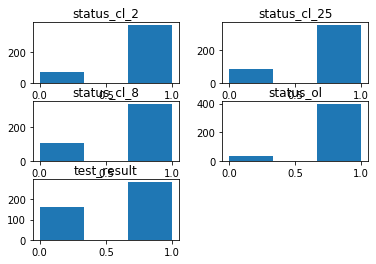

In [12]:
df[columns_with_categorical_data].hist(bins=3, grid=False)

In the above plots, we can see the distribution of Pass (1) and Fail (0) for each of the phase tests and the final "test_result".

Another variable we can investigate is the timestamp.
Is there any correlation between when a test was performed and the results of the test?

Since the data spans from October 2017 to January 2018, we can bin the test data
into a histogram separated into 9 different weeks.

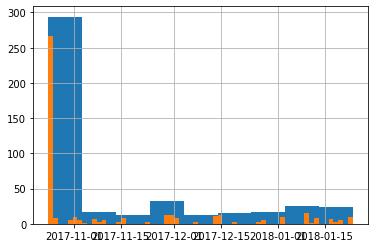

In [13]:
df["date_created"].hist(bins=9)
df["date_created"].hist(bins=63)

The above histogram of dates shows us that the vast majority of tests were created on a single day in November 2018. The blue columns are weeks and the orange columns are days.

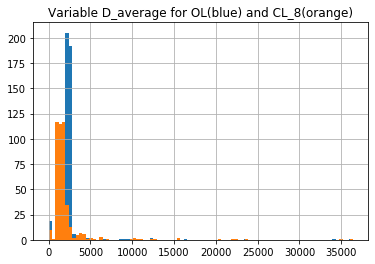

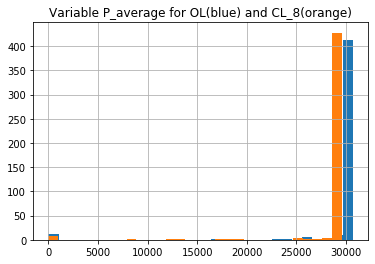

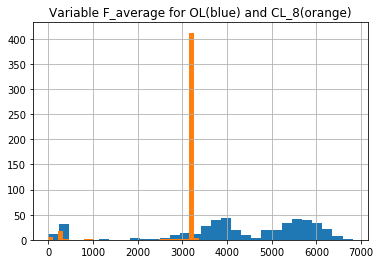

In [14]:
plt.figure(30)
plt.title("Variable D_average for OL(blue) and CL_8(orange)")
df["d_avg_ol"].hist(bins=90)
df["d_avg_cl_8"].hist(bins=90)

plt.figure(40)
plt.title("Variable P_average for OL(blue) and CL_8(orange)")
df["p_avg_ol"].hist(bins=30)
df["p_avg_cl_8"].hist(bins=30)

plt.figure(50)
plt.title("Variable F_average for OL(blue) and CL_8(orange)")
df["f_avg_ol"].hist(bins=30)
df["f_avg_cl_8"].hist(bins=30)

The above plots show how the process variable averages across all the data (Passes and Fails) differ.

While the plots for variables D and P are relatively similar, variable F takes a very different shape with high variance for OL and low variance with some outliers for CL_8.

The next step would be to plot passes and fails with different colors to see what a failed variable looks like. We could also do this with the standard deviation information.

## Create a dictionary to store 
Finally, I also want to create a python dictionary (hash map) of all the serial numbers (keys) which failed the test and the date each was created (values). This could be useful to someone who is querying the database.

In [15]:
failed_widgets = {}

i = 0
while i < df.shape[0]:
    if df["test_result"][i] == 0:
        #print(df["serial_number"][i] + " . . . " + str(df["date_created"][i]))
        failed_widgets[df["serial_number"][i]] = df["date_created"][i]
    i += 1
    
# We can query the date of a known serial number like this:
print(failed_widgets["4A001H"])

2018-01-23 10:49:00


## 4. Conclusion

In [16]:
print(small_correlation_matrix)

              test_result  status_cl_2  status_cl_25  status_cl_8  status_ol
test_result      1.000000     0.556424      0.650110     0.737862   0.399284
status_cl_2      0.556424     1.000000      0.417977     0.612691   0.424966
status_cl_25     0.650110     0.417977      1.000000     0.353256   0.377110
status_cl_8      0.737862     0.612691      0.353256     1.000000   0.269209
status_ol        0.399284     0.424966      0.377110     0.269209   1.000000


The objective was to determine whether any of the test phases should be eliminated. The key point in my analysis is that the test phases in order from most relevant to least relevant are:
1. status_cl_8:  correlation = 0.74
2. status_cl_25: correlation = 0.65
3. status_cl_2:  correlation = 0.56
4. status_ol:    correlation = 0.40

#### Since status_ol is poorly correlated with the final test result, this phase should be eliminated. Since the other 3 phases are more strongly correlated with the final result, all 3 should be kept.

More info at the wikipedia article on [correlation](https://en.wikipedia.org/wiki/Correlation_and_dependence).